In [52]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from PIL import Image
import matplotlib.patches as patches
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection, SamModel, SamProcessor
from typing import List, Tuple 

from data_creation.grounded_sam import GroundedSam
from data_creation.collage_creator import CollageCreator
from utils.image_processing_utils import bbox_from_mask

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## By Hand

In [5]:
def get_boxes(results) -> List[List[List[float]]]:
    return results[0]['boxes'].tolist()


In [16]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open("/home/dcor/orlichter/concept_collage/humanoid_flower.jpeg")
# Check for cats and remote controls
text = "humanoid flower."

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)


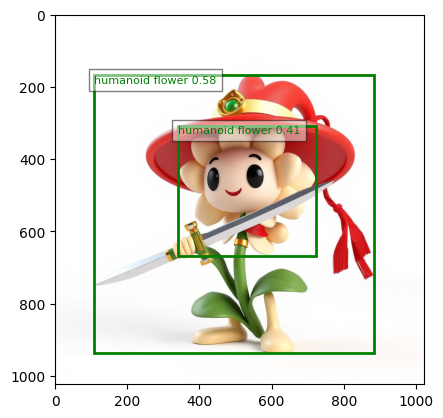

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Define colors for each label
label_colors = {
    'a cat': 'r',
    'a remote control': 'b'
}

for result in results:
    boxes = result['boxes']
    labels = result['labels']
    scores = result['scores']
    for box, label, score in zip(boxes, labels, scores):
        x, y, width, height = box[0].item(), box[1].item(), box[2].item() - box[0].item(), box[3].item() - box[1].item()
        color = label_colors.get(label, 'g')  # Default to green if label not found
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # Add label and confidence score
        ax.text(x, y, f'{label} {score:.2f}', color=color, fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

### Sam

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [19]:
inputs = sam_processor(image, input_boxes=[get_boxes(results)], return_tensors="pt").to(device)
with torch.no_grad():
    outputs = sam_model(**inputs)
masks = sam_processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)

/tmp/ipykernel_1989486/3025769378.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


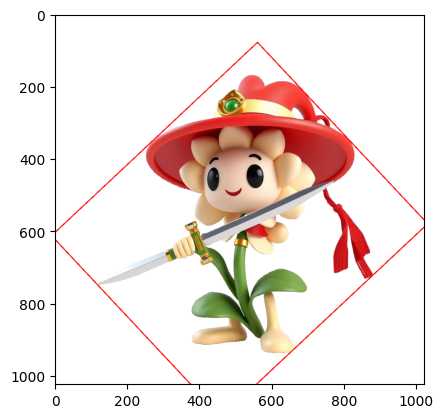

Bounding box coordinates: [[ -10  613]
 [ 560   78]
 [1031  580]
 [ 460 1115]]


In [20]:
import cv2
import numpy as np

# Convert the binary mask to a numpy array
binary_mask = masks[0][0].cpu().numpy().astype(np.uint8) * 255
binary_mask = np.transpose(binary_mask, (1, 2, 0))[..., 0]

# Find contours in the binary mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
copy_image = np.array(image.copy())
copy_image[binary_mask != 255] = [255,255,255]


# Find the minimum area bounding rectangle that holds all contours
if contours:
    all_points = np.vstack(contours)
    rect = cv2.minAreaRect(all_points)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Draw the bounding box on the mask for visualization
    cv2.drawContours(copy_image, [box], 0, (255, 0, 0), 2)

    # Display the mask with the bounding box
    plt.imshow(copy_image)
    plt.show()

    print("Bounding box coordinates:", box)
else:
    print("No contours found in the mask.")

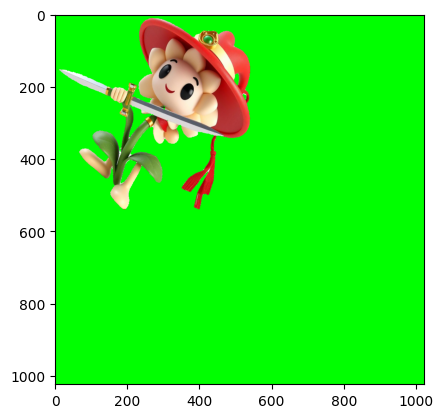

In [23]:
# Define the source and destination points for the warp
src_pts = np.array(box, dtype="float32")
dst_pts = np.array([(10, 10),  (540, 10), (540, 540),(10, 540)], dtype="float32")

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# Warp the bounding box and the mask
warped_image = cv2.warpPerspective(copy_image, M, (copy_image.shape[1], copy_image.shape[0]))
warped_mask = cv2.warpPerspective(binary_mask, M, (binary_mask.shape[1], binary_mask.shape[0]))

# Create a new green image
green_image = np.zeros_like(copy_image)
green_image[:] = [0, 255, 0]

# Use the warped mask to paste the warped bounding box onto the green image
green_image[warped_mask == 255] = warped_image[warped_mask == 255]

# Display the result
plt.imshow(green_image)
plt.show()

/tmp/ipykernel_1959774/2682037243.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 256)


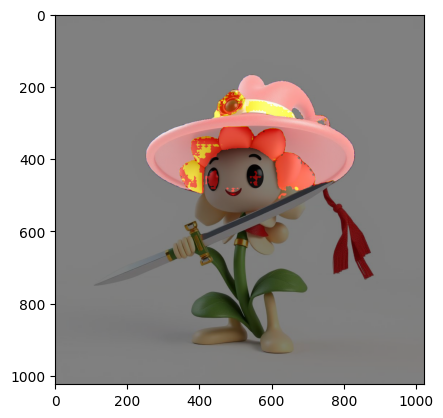

In [134]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Overlay the mask
mask_array = masks[0][0].cpu().numpy().astype(np.float32)  # Convert the mask tensor to a numpy array
mask_array = np.transpose(mask_array, (1, 2, 0))  # Transpose to match the image dimensions

# Create a color map for the mask
cmap = plt.cm.get_cmap('jet', 256)
cmap.set_bad(color='black', alpha=0)

# Overlay the mask on the image
ax.imshow(mask_array, cmap=cmap, alpha=0.5)

plt.show()

## Use Class

### Grounded Sam

In [58]:
source_image = Image.open("/home/dcor/orlichter/concept_collage/cute_sloth.jpeg")
text = "crown"

In [59]:
grounded_sam = GroundedSam()

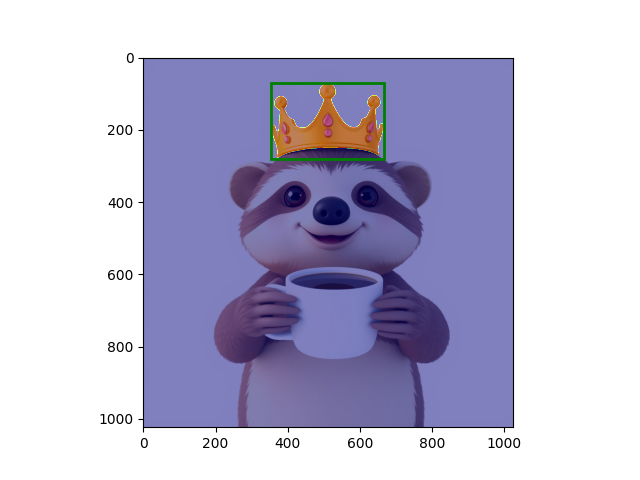

In [60]:
mask, bbox = grounded_sam(source_image, text)
grounded_sam.visualize(source_image, mask, bbox)

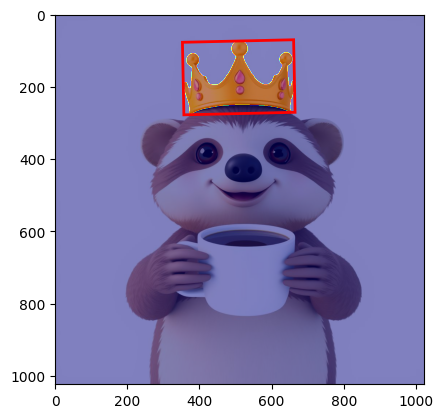

In [ ]:
bbox = bbox_from_mask(mask)


### Collage Creator

In [22]:
source_image = Image.open("/home/dcor/orlichter/concept_collage/cute_sloth.jpeg")
target_image = Image.open("/home/dcor/orlichter/concept_collage/sloth_target.jpeg")
objects_to_detect = [ "sloth", "coffee", "crown"]

In [23]:
collage_creator = CollageCreator()

In [24]:
collage_image = collage_creator.create_collage(source_image, target_image, objects_to_detect)

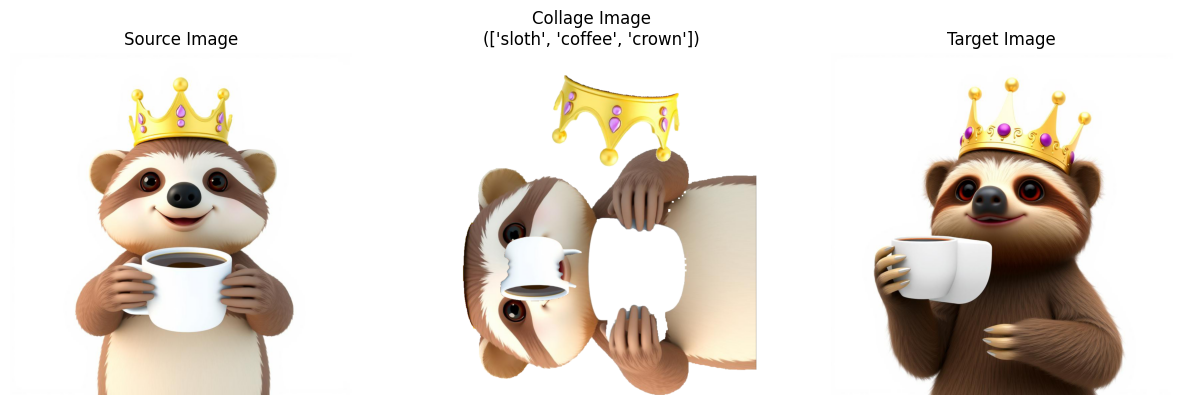

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot source image
axes[0].imshow(source_image)
axes[0].set_title('Source Image')
axes[0].axis('off')

# Plot collage image
axes[1].imshow(collage_image)
axes[1].set_title(f'Collage Image\n({objects_to_detect})')
axes[1].axis('off')

# Plot target image
axes[2].imshow(target_image)
axes[2].set_title('Target Image')
axes[2].axis('off')

plt.show()

In [ ]:
from itertools import permutations
perm = list(permutations([1, 2, 3, 4, 5], 2))
perm[0]

1